<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/04_Explore_Data_DTC_Curate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring HTR3A protein target activity data from Drug Target Commons



# Scope of the tutorial
*   Input data from Excape dataset for HTR3A protein target
*   AMPL will be used to accomplish the following steps: 
  *   Standardize SMILES string
  *   Clean the data (look for duplicates, average the assay data, cluster the compounds etc.)
  *   Curate the data
  *   Carry out some Exploratory Data Analysis (Chemical space exploration; PCA etc.) 
  *   Save the final curated dataset for modeling


Diseases associated with HTR3A include Irritable Bowel Syndrome and Motion Sickness.

# Time on COLAB-Pro ( ~ 3 minutes)

# Protein target (HTR3A) information

The HTR3A target binding data was downloaded from DTC database, https://drugtargetcommons.fimm.fi.

Please refer to the following publication,https://pubmed.ncbi.nlm.nih.gov/29276046/, for details about the database


## Additional information about HTR3A gene:

**Gene location:** Chromosome 11
**Exon count:** 10

mRNA and protein information for its three transcripts:

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 

## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

In [1]:
!date # starting time

Wed May 19 03:40:09 UTC 2021


## Install AMPL  

In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0   7263      0 --:--:-- --:--:-- --:--:--  7263


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 563kB 4.3MB/s 
  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=e2ce04f11365ebbd4317decfa12fcf9be684bee1d12de4da4a7a0ac13ba8ac7d
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap
     |████████████████████████████████| 24.6MB 103.2MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 1.2MB 7.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=f4572f8b5aefb489f48949df3c528dcd803b415ab6bb5f74979d4da05301b4fe
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=f1b7384cc756932f7cc7e26382dde3d4d614eff7f5ce5d9acf22d9205f7544e9
  Stored

In [3]:
import deepchem as dc
dc.__version__

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh


--2021-05-19 03:42:38--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.04K  --.-KB/s    in 0s      

2021-05-19 03:42:38 (55.9 MB/s) - ‘install_AMPL_GPU_test.sh’ saved [1061/1061]

Cloning into 'AMPL'...
remote: Enumerating objects: 2522, done.
remote: Counting objects: 100% (1029/1029), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 2522 (delta 654), reused 924 (delta 586), pack-reused 1493
Receiving objects: 100% (2522/2522), 12.35 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (1455/1455), done.
patching file /content/git

## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor HTR3A

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import os
import requests

In [5]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

## Select a target to work with 
### (e.g. PDE2A, KCNH2, SCNA5)

In [6]:
target_name='HTR3A'

# Define data locations 

In [7]:
# ofile=target_name+'_excape_curated.csv'
ofile=target_name+'_dtc_smiles.csv'

## Note the file `HTR3A_dtc_smiles.csv` was the output from https://github.com/ravichas/AMPL-Tutorial/blob/master/explore_data_dtc_min_viable_one.ipynb notebook

In [8]:
import io
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HTR3A_dtc_smiles.csv'
download = requests.get(url).content

In [9]:
# Reading the downloaded content and turning it into a pandas dataframe
save_smiles_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [10]:
# save_smiles_df.rename( columns={ "PIC50" : "PXC50" }, inplace=True) 

##Check for assay replicates with high measurement variation and flag them 

In [11]:
import os

# From our dataframe, we are working with the PIC50 column 
data=save_smiles_df

# Here we are defining our response column, which will be PIC50
column = 'PIC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'standard_inchi_key'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (197, 52)
List of 'bad' duplicates removed
              standard_inchi_key     PIC50  ...   Perc_Var  VALUE_NUM_std
172  FZGWDCDUMFWUEO-UHFFFAOYSA-N  8.159894  ...  11.975455       1.234152
173  FZGWDCDUMFWUEO-UHFFFAOYSA-N  6.414539  ...  11.975455       1.234152
67   KQKPFRSPSRPDEB-UHFFFAOYSA-N  5.000000  ...  23.262963       2.143606
68   KQKPFRSPSRPDEB-UHFFFAOYSA-N  8.031517  ...  23.262963       2.143606

[4 rows x 5 columns]

Dataset de-duplicated
Dataframe size (170, 52)
New column created with averaged values:  VALUE_NUM_mean


## Examine the rejected compounds and examine them

In [12]:
old_compound_id='rdkit_smiles'
new_compound_id='rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,compound_id,uniprot_id,compound_name,standard_inchi_key,max_phase,target_pref_name,gene_names,target_class,wildtype_or_mutant,mutation_information,pubmed_id,standard_type,standard_relation,standard_value,standard_units,mode_of_action,assay_format,assay_type,assay_sub_type,inhibitor_type,detection_technology,compound_concentration_value,compound_concentration_value_units,substrate_type,substrate_type_standard_relation,substrate_type_standard_value,substrate_type_standard_units,assay_cell_line,assay_description,activity_comments,title,journal,year,volume,issue,authors,annotation_comments,assay_id,dtc_tid,dtc_activity_id,dtc_molregno,record_id,dtc_document_id,PIC50,Unnamed: 0,CID,smiles,rdkit_smiles
67,CHEMBL128,P46098,SUMATRIPTAN,KQKPFRSPSRPDEB-UHFFFAOYSA-N,4,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,7752204.0,IC50,>,10000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding activity radioligand.,NaN,"Synthesis and serotonergic activity of N,N-dim...",J. Med. Chem.,1995.0,38.0,10.0,"Street LJ, Baker R, Davey WB, Guiblin AR, Jell...",NaN,3126.0,DTCT0023221,520894,DTCC00154636,658692,13017,5.000000,110,5358,CNS(=O)(=O)CC1=CC2=C(C=C1)NC=C2CCN(C)C,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1
68,CHEMBL128,P46098,SUMATRIPTAN,KQKPFRSPSRPDEB-UHFFFAOYSA-N,4,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,9357515.0,IC50,=,9.30,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Compound was evaluated for the affinity at 5-h...,NaN,"Selective, orally active 5-HT1D receptor agoni...",J. Med. Chem.,1997.0,40.0,22.0,"MacLeod AM, Street LJ, Reeve AJ, Jelley RA, St...",NaN,3459.0,DTCT0023221,712596,DTCC00154636,659675,14385,8.031517,110,5358,CNS(=O)(=O)CC1=CC2=C(C=C1)NC=C2CCN(C)C,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1
172,CHEMBL470432,P46098,NaN,FZGWDCDUMFWUEO-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19261477.0,IC50,=,6.92,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]granisetron from human rec...,NaN,Novel antagonists of serotonin-4 receptors: sy...,Bioorg. Med. Chem.,2009.0,17.0,6.0,"Lemaître S, Lepailleur A, Bureau R, Butt-Gueul...",NaN,564583.0,DTCT0023221,2613037,DTCC00570224,1082935,33265,8.159894,723,42636941,CCCN1CCC(CC1)COC2=NC3=C(C(=CS3)C)N4C2=CC=C4,CCCN1CCC(COc2nc3scc(C)c3n3cccc23)CC1
173,CHEMBL470432,P46098,NaN,FZGWDCDUMFWUEO-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19261477.0,IC50,=,385.00,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NG108-15,Antagonist activity at 5HT3 receptor in hybrid...,NaN,Novel antagonists of serotonin-4 receptors: sy...,Bioorg. Med. Chem.,2009.0,17.0,6.0,"Lemaître S, Lepailleur A, Bureau R, Butt-Gueul...",NaN,564575.0,DTCT0023221,2613019,DTCC00570224,1082935,33265,6.414539,723,42636941,CCCN1CCC(CC1)COC2=NC3=C(C(=CS3)C)N4C2=CC=C4,CCCN1CCC(COc2nc3scc(C)c3n3cccc23)CC1


In [13]:
# Prints number of unique rejected compound names and rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile = target_name+'.reject_check'

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

Number of discarded compounds 2


In [14]:
# Prints all the results of the unique assay tests run on this target
save_smiles_df['assay_description'].unique()

array(['Inhibitory concentration required against 5-HT3 receptor in bovine area postrema using [3H]GR-65630',
       'Binding affinity to human recombinant serotonin 5HT3 receptor',
       'Agonist activity at human 5HT3A receptor expressed in HEK293 cells by FLIPR assay',
       'Displacement of [3H]granisetron from human recombinant 5-HT3 receptor expressed in HEK293 cells',
       nan,
       'Antagonist activity at human wild type 5-HT3A receptor expressed in HEK293 cells assessed as inhibition of 5-HT-induced response after 45 mins by FLIPR assay',
       'Compound was tested for its affinity towards 5-hydroxytryptamine 3 receptor',
       'Displacement of [3H]BRL 43694 from human recombinant 5HT3 receptor expressed in CHO cells',
       'Antagonist activity at human 5HT3 receptor',
       'Displacement of [3H]BRL-43694 from human 5HT3 receptor expressed in HEK293 cells by liquid scintillation counting',
       'Displacement of [3H]BRL-43694 from human recombinant 5HT3 receptor',


In [15]:
# Collects all the non-rejected data into a new frame called data
data=save_smiles_df[~save_smiles_df[compound_id].isin(reject[compound_id])]

# Prints the rows & columns (in that order) of the dataset from above (i.e. all the matching data)
# Shape is an array that can check how large the dataframe is 
# It will print out (x, y), the x is the rows, or lines, and y is the number of columns 
print(data.shape)

(197, 48)


In [16]:
data[['standard_inchi_key','rdkit_smiles','standard_relation']].head(5)

,standard_inchi_key,rdkit_smiles,standard_relation
0,OSVMSQACZRYAPT-UHFFFAOYSA-N,COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...,>
1,CKLPLPZSUQEDRT-WPCRTTGESA-N,CC1Cc2c([nH]c3cc(Cl)c(F)cc23)C2(N1)C(=O)Nc1ccc...,>
2,YOCUJVXRRWEPDN-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccccc2F)nc1,>
3,LMGUUVWYFJIKCD-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)cc2)nc1,>
4,DFBQTBNRGSIKHN-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)nc2)nc1,>


In [17]:
#specifies the column we want (response value) and also tells it to include the duplicates
column='PIC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='standard_inchi_key', 
                                         smiles_col='rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
170 unique SMILES strings are reduced to 170 unique base SMILES strings


## Save data to a file

In [18]:
# prints the number of rows in the before and after curation 
print("before",data.shape[0],"after",curated_df.shape[0])

#prints the first few rows of the "after" (after curation) dataframes
curated_df.head()

before 197 after 170


,compound_id,base_rdkit_smiles,relation,PIC50,active
0,ILPANLYEJQKXKY-UHFFFAOYSA-N,CN(C)Cc1nc(-c2ccc(C(C)(C)C)cc2)n(-c2cccc(O)c2)n1,>,5.000000,0
1,KINBZTGMJRQTER-UHFFFAOYSA-N,O=C(NCCN1CCOCC1)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(=...,,4.801343,0
2,YUIBGCSVGUWIHQ-UHFFFAOYSA-L,C[N+](C)(C)Cc1c2n(c3ccccc13)Cc1c(C[N+](C)(C)C)...,>,4.000000,0
3,FALASSBEVXPICK-UHFFFAOYSA-N,CCCn1c(=O)[nH]c2cc(C(=O)NCCN3CCCCC3)ccc2c1=O,,5.657577,0
4,POJMJIIKSJRQPV-QZOFJNMOSA-N,COc1cccc(C2(O)CCCCC2CN2CCC(NC(=O)c3cc(Cl)c(N)c...,,6.284077,1


In [19]:
# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile = target_name+'.reject_check'

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

Number of discarded compounds 2


In [20]:
# specifies file path to save the curated data to
ofile = target_name+'_dtc_smiles_curated.csv'

# sends data from the curated_df to csv with specified path above
curated_df.to_csv(ofile,index=False)

(0.0, 12.0)

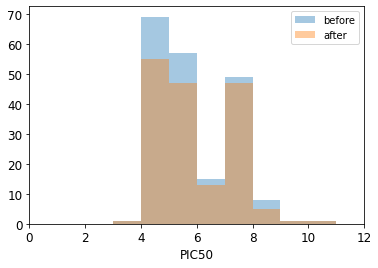

In [21]:
# load graphics libraries matplotlib and seaborn (sns)
import matplotlib.pyplot as plt
import seaborn as sns

# plt.subplots is a function that creates a full grid of subplots in a single array, and returning 
# them in a NumPy array
# A NumPy array is a grid of values, all of the same type, and is indexed by a tubule of nonnegative integers 
# We are saving this subplots we're creating as fig, ax variables
fig, ax = plt.subplots()

# compiles the data frames before and after all the curation with the specified column value (response values)
# If we remember or look up further in the notebook, we created two dataframes: data and curated_df 
# Our data dataframe consists of ofile (target_name+'_excape_curated.csv.') and we will be using the PIC50 column of our dataframe
# This will be our before variable
before=save_smiles_df["PIC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["PIC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])


In [22]:
!date # ending time

Wed May 19 03:43:00 UTC 2021
